## Homework 1 - NLP

In [205]:
import numpy as np
import pandas as pd
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import joblib
from xgboost import XGBClassifier

## Preprocessing of Train Dataset

In [206]:
# load dataset
df_train = pd.read_csv('train.csv',encoding='latin1')
print('Training Set Shape = {}'.format(df_train.shape))

Training Set Shape = (7320, 3)


In [207]:
df_train.head()

,Id,text,Target
0,1,@USAirways ! THE WORST in customer service. @...,-1
1,2,@united call wait times are over 20 minutes an...,-1
2,3,@JetBlue what's up with the random delay on fl...,-1
3,4,@AmericanAir Good morning! Wondering why my p...,0
4,5,@united UA 746. Pacific Rim and Date Night cut...,-1


### Analyzing Text Data for number of mentions, hastags, question marks, url, emojis

In [208]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #all the alphanumeric character
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        data = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return data

In [209]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

data_eda = tc.fit_transform(df_train.text)
data_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,18,2,2,2,3,0,0
1,14,1,0,0,0,0,0
2,19,1,0,0,2,0,0
3,17,1,0,1,2,0,0
4,18,1,0,1,0,0,0


In [210]:
data_eda['Target'] = df_train.Target
data_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,Target
0,18,2,2,2,3,0,0,-1
1,14,1,0,0,0,0,0,-1
2,19,1,0,0,2,0,0,-1
3,17,1,0,1,2,0,0,0
4,18,1,0,1,0,0,0,-1


### Cleaning Text data (Train Dataset):

#### Changed text to lower case and Removed numbers, URLs, digits, websites, html tags, single alphabets, Special Characaters

In [211]:
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"\d+", "", elem))
    #remove urls
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'http.?://[^\s]+[\s]?', '', elem))
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'{html}', '', elem))
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'<.*?>', '', elem))
    
    return df

data_clean = clean_text(df_train, 'text')
data_clean.head()

,Id,text,Target
0,1,the worst in customer service calling for...,-1
1,2,call wait times are over minutes and airport...,-1
2,3,whats up with the random delay on flight any...,-1
3,4,good morning wondering why my pretsa check w...,0
4,5,ua pacific rim and date night cut out not co...,-1


### Removed Wh words and negative words from Stopword dictionary which might changed the sentiment of the text data

In [212]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

stop_words = set(stopwords.words('english')) - set(["who", "what", "when", "why", "how", "which", "where", "whom", "no", "not", "weren't", "aren't","didn't", "wasn't", "couldn't", "hadn't","hasn't", "doesn't", "shouldn't", "isn't", "wouldn't", "don't", "mightn't", "won't", "haven't", "mustn", "ain","hasn", "weren", "mustn't", "wasn", "didn", "hadn", "don", "haven", "shouldn", "shan't", "isn", "wouldn", "mightn", "couldn", "needn't", "doesn" ])
print("\nList of fresh stopwords in English:")
print (stop_words)
print (len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [213]:
data_clean['text'] = data_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data_clean.head()

,Id,text,Target
0,1,worst customer service calling month book flig...,-1
1,2,call wait times minutes airport wait times longer,-1
2,3,whats random delay flight chance false alarm,-1
3,4,good morning wondering why pretsa check not bo...,0
4,5,ua pacific rim date night cut not constantly r...,-1


In [214]:
import spacy
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn import linear_model
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ektam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Stemming using Porter Stemmer
#### Used Porter and Snowball Stemmer both to check which technique is better, Porter stemmer is giving more accurate results.

In [215]:
class CleanText(BaseEstimator, TransformerMixin):
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.stemming)
        return clean_X

In [216]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(data_clean.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

9 records have no words left after text cleaning


In [217]:
type(sr_clean)

pandas.core.series.Series

In [218]:
sr_clean.head()

0    worst custom servic call month book flight poo...
1        call wait time minut airport wait time longer
2            what random delay flight chanc fals alarm
3    good morn wonder whi pretsa check not board pa...
4    ua pacif rim date night cut not constantli ran...
Name: text, dtype: object

### Spacy Lemmatization

In [219]:
nlp = spacy.load('en_core_web_sm')

In [220]:
sr_clean.apply(lambda x: [y.lemma_ for y in  nlp(x)])

0       [bad, custom, servic, call, month, book, fligh...
1       [call, wait, time, minut, airport, wait, time,...
2        [what, random, delay, flight, chanc, fal, alarm]
3       [good, morn, wonder, whi, pretsa, check, not, ...
4       [ua, pacif, rim, date, night, cut, not, consta...
                              ...                        
7315                                         [followback]
7316      [thank, help, wish, phone, rep, could, accomid]
7317                     [bad, ever, dca, customerservic]
7318                      [look, anoth, apolog, not, fli]
7319    [far, bad, airlin, plane, delay, round, trip, ...
Name: text, Length: 7320, dtype: object

In [221]:
i=1
empty_clean = sr_clean == ''


print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    worst custom servic call month book flight poo...
1        call wait time minut airport wait time longer
2            what random delay flight chanc fals alarm
3    good morn wonder whi pretsa check not board pa...
4    ua pacif rim date night cut not constantli ran...
Name: text, dtype: object


#### Checking frequency of words

In [222]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
#printing only first 20
cv.get_feature_names()[0:20]
#bow.sum(axis=0)

['aa',
 'aadvantag',
 'aafail',
 'aaso',
 'ab',
 'abandon',
 'abassinet',
 'abc',
 'abcnew',
 'abi',
 'abil',
 'abl',
 'aboard',
 'aboout',
 'abound',
 'abq',
 'absolut',
 'absoulut',
 'absurd',
 'absurdli']

      word  freq
0   flight  2378
1    thank   855
2      get   820
3      not   787
4       no   749
5     hour   587
6   cancel   549
7     help   528
8   servic   494
9    delay   487
10    time   479
11  custom   469
12    call   406
13    what   402
14     bag   397
15    wait   381
16      im   373
17     fli   366
18   plane   354
19      us   352


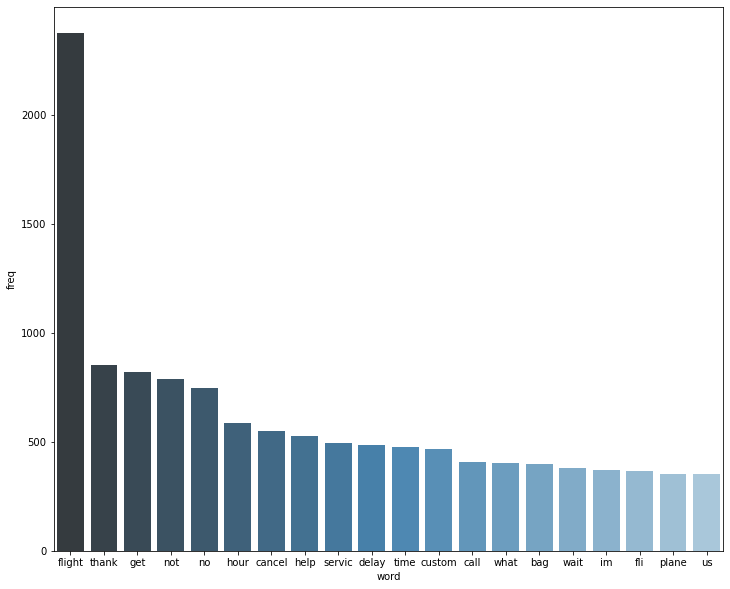

In [223]:
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
print(word_counter_df)

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="Blues_d", ax=ax)
plt.show();

In [224]:
data_model = data_eda
data_model['clean_text'] = sr_clean
data_model.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'Target',
 'clean_text']

In [225]:
data_model.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,Target,clean_text
0,18,2,2,2,3,0,0,-1,worst custom servic call month book flight poo...
1,14,1,0,0,0,0,0,-1,call wait time minut airport wait time longer
2,19,1,0,0,2,0,0,-1,what random delay flight chanc fals alarm
3,17,1,0,1,2,0,0,0,good morn wonder whi pretsa check not board pa...
4,18,1,0,1,0,0,0,-1,ua pacif rim date night cut not constantli ran...


## Preprocessing of Test Data

In [226]:
# load dataset
df_test = pd.read_csv('test.csv',encoding='latin1')
print('Test Set Shape = {}'.format(df_test.shape))

Test Set Shape = (7320, 2)


### Analyzing Text Data for number of mentions, hastags, question marks, url, emojis

In [227]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        #finding all the substring containing the pattern in the tweet
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #all the alphanumeric character
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?+', x))
        count_urls = X.apply(lambda x: self.count_regex(r'https?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        data = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return data

In [228]:
from sklearn.feature_extraction.text import CountVectorizer

tc = TextCounts()

test_eda = tc.fit_transform(df_test.text)
test_eda.head()

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis
0,28,1,0,2,1,0,0
1,19,1,0,1,0,0,0
2,25,1,0,1,1,0,0
3,18,1,0,1,0,0,0
4,9,1,0,1,1,0,0


### Cleaning Text Data (Test Dataset):

#### Changed text to lower case, Removed numbers, URLs, digits, websites, html tags, single alphabets, Special Characaters

In [229]:
import re
def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"\d+", "", elem))
    #remove urls
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'http.?://[^\s]+[\s]?', '', elem))
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'{html}', '', elem))
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r'<.*?>', '', elem))                                      
    return df

test_clean = clean_text(df_test, 'text')
test_clean.head()

,id,text
0,7322,in car gng to dfw pulled over hr ago very ic...
1,7323,after all the plane didnt land in identical o...
2,7324,cant believe how many paying customers you le...
3,7325,i can legitimately say that i would have rath...
4,7326,still no response from aa great job guys


### Removed Wh words and negative words from Stopword dictionary which might changed the sentiment of the text data

In [230]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

stop_words = set(stopwords.words('english')) - set(["who", "what", "when", "why", "how", "which", "where", "whom", "no", "not", "weren't", "aren't","didn't", "wasn't", "couldn't", "hadn't","hasn't", "doesn't", "shouldn't", "isn't", "wouldn't", "don't", "mightn't", "won't", "haven't", "mustn", "ain","hasn", "weren", "mustn't", "wasn", "didn", "hadn", "don", "haven", "shouldn", "shan't", "isn", "wouldn", "mightn", "couldn", "needn't", "doesn" ])
print("\nList of fresh stopwords in English:")
print (stop_words)
print (len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [231]:
test_clean['text'] = test_clean['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_clean.head()

,id,text
0,7322,car gng dfw pulled hr ago icy roads onhold aa ...
1,7323,plane didnt land identical worse conditions gr...
2,7324,cant believe how many paying customers left hi...
3,7325,legitimately say would rather driven cross cou...
4,7326,still no response aa great job guys


### Stemming using Porter Stemmer
#### Used Porter and Snowball Stemmer both to check which technique is better, Porter stemmer is giving more accurate results.

In [232]:
import spacy
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn import linear_model
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ektam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [233]:
class CleanText(BaseEstimator, TransformerMixin):
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.stemming)
        return clean_X

In [234]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
ct = CleanText()
sr_clean = ct.fit_transform(test_clean.text)
sr_clean.sample(5)
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

9 records have no words left after text cleaning


In [235]:
sr_clean.head()

0    car gng dfw pull hr ago ici road onhold aa sin...
1    plane didnt land ident wors condit grk accord ...
2    cant believ how mani pay custom left high dri ...
3    legitim say would rather driven cross countri ...
4                    still no respons aa great job guy
Name: text, dtype: object

### Spacy Lemmatization

In [236]:
nlp = spacy.load('en_core_web_sm')

In [237]:
sr_clean.apply(lambda x: [y.lemma_ for y in  nlp(x)])

0       [car, gng, dfw, pull, hr, ago, ici, road, onho...
1       [plane, do, not, land, ident, wor, condit, grk...
2       [can, not, believ, how, mani, pay, custom, lea...
3       [legitim, say, would, rather, drive, cross, co...
4                [still, no, respon, aa, great, job, guy]
                              ...                        
7315    [travel, two, kid, tomorrow, age, domest, need...
7316    [tx, info, do, not, understand, whi, could, no...
7317    [understand, whi, flight, day, not, go, twice,...
7318                                             [realli]
7319    [no, not, make, connect, stellar, employe, vic...
Name: text, Length: 7320, dtype: object

In [238]:
i=1
empty_clean = sr_clean == ''

print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'
print (sr_clean[0:5])

0 records have no words left after text cleaning
0    car gng dfw pull hr ago ici road onhold aa sin...
1    plane didnt land ident wors condit grk accord ...
2    cant believ how mani pay custom left high dri ...
3    legitim say would rather driven cross countri ...
4                    still no respons aa great job guy
Name: text, dtype: object


#### Checking frequency of words

In [239]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
#printing only first 20
cv.get_feature_names()[0:20]
#bow.sum(axis=0)

['aa',
 'aaaand',
 'aaadvantag',
 'aaalwaysl',
 'aaba',
 'aacom',
 'aadavantag',
 'aadelay',
 'aadfw',
 'aadv',
 'aadvantag',
 'aafail',
 'aal',
 'aampc',
 'aano',
 'aaron',
 'aateam',
 'aau',
 'aback',
 'abandon']

      word  freq
0   flight  2428
1    thank   833
2      get   797
3      not   777
4       no   722
5     hour   563
6     help   514
7   cancel   507
8   servic   495
9    delay   493
10    time   480
11  custom   467
12    what   417
13      im   391
14   plane   366
15    wait   364
16    call   362
17     bag   359
18      us   353
19    hold   351


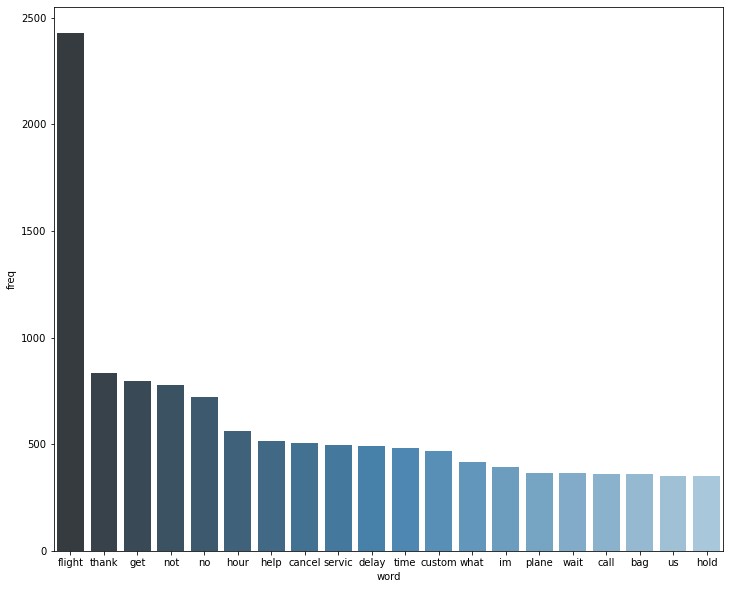

In [240]:
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
print(word_counter_df)

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="Blues_d", ax=ax)
plt.show();

In [241]:
data_test = test_eda
data_test['clean_text'] = sr_clean
data_test.columns.tolist()

['count_words',
 'count_mentions',
 'count_hashtags',
 'count_capital_words',
 'count_excl_quest_marks',
 'count_urls',
 'count_emojis',
 'clean_text']

In [242]:
data_test

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,clean_text
0,28,1,0,2,1,0,0,car gng dfw pull hr ago ici road onhold aa sin...
1,19,1,0,1,0,0,0,plane didnt land ident wors condit grk accord ...
2,25,1,0,1,1,0,0,cant believ how mani pay custom left high dri ...
3,18,1,0,1,0,0,0,legitim say would rather driven cross countri ...
4,9,1,0,1,1,0,0,still no respons aa great job guy
...,...,...,...,...,...,...,...,...
7315,21,1,0,0,1,0,0,travel two kid tomorrow age domest need birth ...
7316,24,1,0,0,0,0,0,tx info dont understand whi couldnt accur esti...
7317,28,1,0,0,3,0,0,understand whi flight day not go twice im extr...
7318,2,1,0,0,2,0,0,realli


### Model Evaluation

In [244]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        #print("I am in")
        
        #print(X[self.cols].dtype())
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

### Splitting Data (70:30)
#### Note: I checked the accuracy by splitting data 75:25 and 70:30 (Train and Test). 70:30 division is providing better accuracy.

In [245]:
X_train, X_test, y_train, y_test = train_test_split(data_model.drop('Target', axis=1), data_model.Target, test_size=0.30, random_state=0)

#### Defined Scoring method as F1 Macro

In [246]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        print("not good")
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        print("ok")
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)
    
    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5, scoring='f1_macro')
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Train score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_train, y_train))
    print("\n")
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    print("Classification Report Train Data")
    print(classification_report(y_train, grid_search.best_estimator_.predict(X_train)))                    
    return grid_search

### Parameters for GridSearch (with n-gram bag of words approach)

In [247]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1,1), (1,2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.10,0.25, 0.5, 0.75,1.0,1.25)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (1.05, 1.10,1.15,1.20,1.25),
    'clf__penalty': ('l1', 'l2'),
    'clf__multi_class':['auto'],
    'clf__solver':['lbfgs', 'liblinear'],
    'clf__max_iter': [500]
}

# Parameter grid settings for XGBoost 
parameters_xgboost = {
    'clf__min_child_weight': (1,5),
    'clf__gamma': (0.5,1,1.5,2),
}

In [248]:
mnb = MultinomialNB()
logreg = LogisticRegression()
xgboost = XGBClassifier()

#### Using three Vectorization techniques Count, Tfidf and Hash with Machine learning models

## 1.Count Vectorization

In [251]:
countvect = CountVectorizer()

### Naïve Bayes with Count Vectorization

In [252]:
mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.1, 0.25, 0.5, 0.75, 1.0, 1.25),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   20.2s finished


done in 20.507s

Best CV score: 0.690
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.906


Test score with best_estimator_: 0.772


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.85      0.88      0.87      1414
           0       0.55      0.46      0.50       437
           1       0.68      0.71      0.70       345

    accuracy                           0.77      2196
   macro avg       0.69      0.69      0.69      2196
weighted avg       0.76      0.77      0.77      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.94      0.93      0.94      3152
           0       0.83      0.84      0.84      1099
           1       0.87      0.90      0.89       873

    accuracy                           0.91      5124
   macro a

In [253]:
mnb_countvect_predict = mnb_countvect.predict(data_test)

In [254]:
mnb_countvect_predict1 = pd.DataFrame(mnb_countvect_predict,index=df_test.index,columns=['Target'])
mnb_countvect_predict1

,Target
0,-1
1,-1
2,-1
3,0
4,-1
...,...
7315,0
7316,-1
7317,-1
7318,1


### Logistic with Count Vectorization

In [250]:
logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2, 1.25),
 'clf__max_iter': [500],
 'clf__multi_class': ['auto'],
 'clf__penalty': ('l1', 'l2'),
 'clf__solver': ['lbfgs', 'liblinear'],
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 10.8min finished


done in 649.291s

Best CV score: 0.714
Best parameters set:
	clf__C: 1.1
	clf__max_iter: 500
	clf__multi_class: 'auto'
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.930


Test score with best_estimator_: 0.796


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.85      0.91      0.88      1414
           0       0.62      0.52      0.57       437
           1       0.75      0.67      0.71       345

    accuracy                           0.80      2196
   macro avg       0.74      0.70      0.72      2196
weighted avg       0.79      0.80      0.79      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.94      0.98      0.96      3152
           0       0.90      0.84      0.87      1099
           1       0.93      0.

In [255]:
logreg_countvect_predict = logreg_countvect.predict(data_test)

In [256]:
logreg_countvect_predict1 = pd.DataFrame(logreg_countvect_predict,index=df_test.index,columns=['Target'])
logreg_countvect_predict1

,Target
0,-1
1,-1
2,-1
3,0
4,-1
...,...
7315,0
7316,-1
7317,-1
7318,0


### Xgboost with Count Vectorisation

In [258]:
xgboost_countvect = grid_vect(xgboost, parameters_xgboost, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__gamma': (0.5, 1, 1.5, 2),
 'clf__min_child_weight': (1, 5),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  8.4min finished


done in 503.354s

Best CV score: 0.703
Best parameters set:
	clf__gamma: 0.5
	clf__min_child_weight: 1
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.890


Test score with best_estimator_: 0.782


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.83      0.91      0.87      1414
           0       0.61      0.51      0.56       437
           1       0.75      0.60      0.67       345

    accuracy                           0.78      2196
   macro avg       0.73      0.67      0.70      2196
weighted avg       0.77      0.78      0.77      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.90      0.96      0.93      3152
           0       0.83      0.77      0.79      1099
           1       0.92      0.79      0.85       873

    accuracy                           

In [259]:
xgboost_countvect_predict = xgboost_countvect.predict(data_test)

In [260]:
xgboost_countvect_predict1 = pd.DataFrame(xgboost_countvect_predict,index=df_test.index,columns=['Target'])
xgboost_countvect_predict1

,Target
0,-1
1,-1
2,-1
3,-1
4,1
...,...
7315,0
7316,-1
7317,-1
7318,1


## 2.Tfidf Vectorization

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvect = TfidfVectorizer()

### Naïve Bayes with Tfidf

In [73]:
multinomialnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.1, 0.25, 0.5, 0.75, 1.0, 1.25),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.0s finished


done in 16.243s

Best CV score: 0.635
Best parameters set:
	clf__alpha: 0.1
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.900


Test score with best_estimator_: 0.770


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.80      0.95      0.86      1414
           0       0.64      0.36      0.46       437
           1       0.73      0.57      0.64       345

    accuracy                           0.77      2196
   macro avg       0.72      0.63      0.66      2196
weighted avg       0.75      0.77      0.75      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.89      0.97      0.93      3152
           0       0.90      0.75      0.82      1099
           1       0.92      0.82      0.87       873

    accuracy                           0.90      5124
   macro av

In [74]:
multinomialnb_tfidf_predict = multinomialnb_tfidf.predict(data_test)

In [75]:
multinomialnb_tfidf_predict1 = pd.DataFrame(multinomialnb_tfidf_predict,index=df_test.index,columns=['Target'])
multinomialnb_tfidf_predict1

,Target
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
7315,-1
7316,-1
7317,-1
7318,1


### Logistic with Tfidf

In [67]:
logisticreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1, 1.15, 1.2, 1.25),
 'clf__max_iter': [500],
 'clf__multi_class': ['auto'],
 'clf__penalty': ('l1', 'l2'),
 'clf__solver': ['lbfgs'],
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  9.8min finished


done in 588.604s

Best CV score: 0.697
Best parameters set:
	clf__C: 1.1
	clf__max_iter: 500
	clf__multi_class: 'auto'
	clf__penalty: 'l2'
	clf__solver: 'lbfgs'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.878


Test score with best_estimator_: 0.791


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.82      0.94      0.88      1414
           0       0.66      0.46      0.55       437
           1       0.78      0.58      0.66       345

    accuracy                           0.79      2196
   macro avg       0.75      0.66      0.70      2196
weighted avg       0.78      0.79      0.78      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.87      0.98      0.92      3152
           0       0.87      0.70      0.77      1099
           1       0.94      0.73  

C:\Users\ektam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [68]:
logisticreg_tfidf_predict = logisticreg_tfidf.predict(data_test)

In [69]:
logisticreg_tfidf_predict1 = pd.DataFrame(logisticreg_tfidf_predict,index=df_test.index,columns=['Target'])
logisticreg_tfidf_predict1

,Target
0,-1
1,-1
2,-1
3,0
4,-1
...,...
7315,-1
7316,-1
7317,-1
7318,1


### Xgboost with Tfidf

In [76]:
xgboost_tfidf = grid_vect(xgboost, parameters_xgboost, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__gamma': (0.5, 1, 1.5, 2),
 'clf__min_child_weight': (1, 5),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 13.1min finished


done in 794.370s

Best CV score: 0.705
Best parameters set:
	clf__gamma: 0.5
	clf__min_child_weight: 1
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.912


Test score with best_estimator_: 0.778


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.84      0.89      0.87      1414
           0       0.60      0.53      0.57       437
           1       0.69      0.62      0.65       345

    accuracy                           0.78      2196
   macro avg       0.71      0.68      0.69      2196
weighted avg       0.77      0.78      0.77      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.93      0.96      0.94      3152
           0       0.85      0.83      0.84      1099
           1       0.94      0.83      0.88       873

    accuracy                          

In [77]:
xgboost_tfidf_predict = xgboost_tfidf.predict(data_test)

In [78]:
xgboost_tfidf_predict1 = pd.DataFrame(xgboost_tfidf_predict,index=df_test.index,columns=['Target'])
xgboost_tfidf_predict1

,Target
0,-1
1,-1
2,-1
3,-1
4,1
...,...
7315,0
7316,-1
7317,-1
7318,0


## 3.Hash Vectorization

In [43]:
from sklearn.feature_extraction.text import HashingVectorizer
Hashvect = HashingVectorizer()

In [44]:
# Parameter grid settings for the vectorizers (Hash)
parameters_vect1 = {
    'features__pipe__vect__ngram_range': ((1,1), (1,2))
}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (1.05, 1.10),
    'clf__penalty': ('l1', 'l2'),
    'clf__multi_class':['auto'],
    'clf__solver':['lbfgs'],
    'clf__max_iter': [50]
}

# Parameter grid settings for XGBoost 
parameters_xgboost = {
    'clf__min_child_weight': (1,2),
    'clf__gamma': (0.5,1),
}

### Logistic with HashVectorization

In [45]:
logreg_Hashvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect1, vect=Hashvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (1.05, 1.1),
 'clf__max_iter': [50],
 'clf__multi_class': ['auto'],
 'clf__penalty': ('l1', 'l2'),
 'clf__solver': ['lbfgs'],
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  8.4min finished
C:\Users\ektam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


done in 545.328s

Best CV score: 0.558
Best parameters set:
	clf__C: 1.05
	clf__max_iter: 50
	clf__multi_class: 'auto'
	clf__penalty: 'l2'
	clf__solver: 'lbfgs'
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.713


Test score with best_estimator_: 0.722


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.76      0.93      0.83      1414
           0       0.52      0.30      0.38       437
           1       0.69      0.42      0.52       345

    accuracy                           0.72      2196
   macro avg       0.65      0.55      0.58      2196
weighted avg       0.70      0.72      0.69      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.74      0.93      0.82      3152
           0       0.55      0.30      0.39      1099
           1       0.73      0.45      0.56       873

    accuracy                           0.71      

In [46]:
logreg_Hashvect_predict = logreg_Hashvect.predict(data_test)

In [47]:
logreg_Hashvect_predict1 = pd.DataFrame(logreg_Hashvect_predict,index=df_test.index,columns=['Target'])
logreg_Hashvect_predict1

,Target
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
7315,-1
7316,-1
7317,-1
7318,1


### Xgboost with HashVectorization

In [48]:
xgboost_Hashvect = grid_vect(xgboost, parameters_xgboost, X_train, X_test, parameters_text=parameters_vect1, vect=Hashvect)

ok
Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__gamma': (0.5, 1),
 'clf__min_child_weight': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 52.8min finished


done in 3300.706s

Best CV score: 0.696
Best parameters set:
	clf__gamma: 0.5
	clf__min_child_weight: 2
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.897


Test score with best_estimator_: 0.784


Classification Report Test Data
              precision    recall  f1-score   support

          -1       0.83      0.91      0.87      1414
           0       0.61      0.51      0.55       437
           1       0.74      0.61      0.67       345

    accuracy                           0.78      2196
   macro avg       0.73      0.68      0.70      2196
weighted avg       0.77      0.78      0.78      2196

Classification Report Train Data
              precision    recall  f1-score   support

          -1       0.91      0.96      0.93      3152
           0       0.84      0.77      0.80      1099
           1       0.92      0.82      0.87       873

    accuracy                           0.90      5124
   macro avg       0.89      0.85      0.87      512

In [49]:
xgboost_Hashvect_predict = xgboost_Hashvect.predict(data_test)

In [50]:
xgboost_Hashvect_predict1 = pd.DataFrame(xgboost_Hashvect_predict,index=df_test.index,columns=['Target'])
xgboost_Hashvect_predict1

,Target
0,-1
1,-1
2,-1
3,-1
4,1
...,...
7315,0
7316,-1
7317,-1
7318,0


### Logistic Regression with Count Vectorization gives highest accuracy score (F1 Score). Therefore, I used the same model to predict target values for test dataset.

In [261]:
# Create predictions to be submitted!
pd.DataFrame({'Id': df_test.id, 'Target': logreg_countvect_predict}).to_csv('solution_base.csv', index =False)  
print("Done :D")

Done :D
